# Music recommender system

One of the most used machine learning algorithms is recommendation systems. A **recommender** (or recommendation) **system** (or engine) is a filtering system which aim is to predict a rating or preference a user would give to an item, eg. a film, a product, a song, etc.

Which type of recommender can we have?   

There are two main types of recommender systems: 
- Content-based filters
- Collaborative filters
  
> Content-based filters predicts what a user likes based on what that particular user has liked in the past. On the other hand, collaborative-based filters predict what a user like based on what other users, that are similar to that particular user, have liked.

We have previously developed a content-based recommendation system. Now, we'll look into collaborative filtering. 

### 2) Collaborative filters

Collaborative Filters work with an interaction matrix, also called rating matrix. The aim of this algorithm is to learn a function that can predict if a user will benefit from an item - meaning the user will likely buy, listen to, watch this item.

Among collaborative-based systems, we can encounter two types: **user-item** filtering and **item-item** filtering. 

*What algorithms do collaborative filters use to recommend new songs?* There are several machine learning algorithms that can be used in the case of collaborative filtering. Among them, we can mention nearest-neighbor, clustering, and matrix factorization.

**K-Nearest Neighbors (kNN)** is considered the standard method when it comes to both user-based and item-based collaborative filtering approaches.
  
We'll go through the steps for generating a music recommender system using a k-nearest algorithm approach.

### Importing required libraries

First, we'll import all the required libraries.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy.sparse import csr_matrix

In [4]:
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import numpy as np

class Recommender:
    def __init__(self, metric, algorithm, k, data, decode_id_song):
        self.metric = metric
        self.algorithm = algorithm
        self.k = k
        self.data = data
        self.decode_id_song = decode_id_song
        self.data = data
        self.model = self._recommender().fit(data)
    
    def make_recommendation(self, new_song, n_recommendations):
        recommended = self._recommend(new_song=new_song, n_recommendations=n_recommendations)
        print("... Done")
        return recommended 
    
    def _recommender(self):
        return NearestNeighbors(metric=self.metric, algorithm=self.algorithm, n_neighbors=self.k, n_jobs=-1)
    
    def _recommend(self, new_song, n_recommendations):
        # Get the id of the recommended songs
        recommendations = []
        recommendation_ids = self._get_recommendations(new_song=new_song, n_recommendations=n_recommendations)
        # return the name of the song using a mapping dictionary
        recommendations_map = self._map_indeces_to_song_title(recommendation_ids)
        # Translate this recommendations into the ranking of song titles recommended
        for i, (idx, dist) in enumerate(recommendation_ids):
            recommendations.append(recommendations_map[idx])
        return recommendations
                 
    def _get_recommendations(self, new_song, n_recommendations):
        # Get the id of the song according to the text
        recom_song_id = self._fuzzy_matching(song=new_song)
        # Start the recommendation process
        print(f"Starting the recommendation process for {new_song} ...")
        # Return the n neighbors for the song id
        distances, indices = self.model.kneighbors(self.data[recom_song_id], n_neighbors=n_recommendations+1)
        return sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    def _map_indeces_to_song_title(self, recommendation_ids):
        # get reverse mapper
        return {song_id: song_title for song_title, song_id in self.decode_id_song.items()}
    
    def _fuzzy_matching(self, song):
        match_tuple = []
        # get match
        for title, idx in self.decode_id_song.items():
            ratio = fuzz.ratio(title.lower(), song.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print(f"The recommendation system could not find a match for {song}")
            return
        return match_tuple[0][1]

### Reading the files

We are going to use the **[Million Song Dataset](http://millionsongdataset.com/)**, a freely-available collection of audio features and metadata for a million contemporary popular music tracks. 

There are two files that will be interesting for us. The first of them will give us information about the songs. Particularly, it contains the user ID, song ID and the listen count. On the other hand, the second file will contain song ID, title of that song, release, artist name and year. 
We need to merge these two DataFrames. For that aim, we'll use the `song_ID` 

In [5]:
df=pd.read_csv('kaggle_visible_evaluation_triplets.txt',sep='\t', names=['user_id','song_id','frequency'])

In [6]:
df1=pd.read_csv('unique_tracks.txt',sep='<SEP>',names=['track_id', 'song_id', 'artist_name', 'release'])

<ipython-input-6-7921ca581fcb>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df1=pd.read_csv('unique_tracks.txt',sep='<SEP>',names=['track_id', 'song_id', 'artist_name', 'release'])


In [7]:
ds=pd.merge(df, df1.drop_duplicates(['song_id']), on='song_id', how='inner')

In [42]:


#Merge the two dataframes above to create input dataframe for recommender systems
songs = ds.iloc[0:500000,:]

In [43]:
songs.tail()

,user_id,song_id,frequency,track_id,artist_name,release
499995,c3fc6e99824f08723bb65522a60226665ca68d13,SORHRZS12AB0185CC2,1,TRUAJPS12903CAE9D5,Jason Collett,Got The Glory
499996,77241419b32b8c1802d3f91e3c9ebc4c8b657ec1,SORHRZS12AB0185CC2,1,TRUAJPS12903CAE9D5,Jason Collett,Got The Glory
499997,a4d4c28313f7e1b3c207b19bb75f09416aa6ee9a,SORHRZS12AB0185CC2,11,TRUAJPS12903CAE9D5,Jason Collett,Got The Glory
499998,273d10f6a884df48672fe2e4b8077cc215d9620f,SORHRZS12AB0185CC2,5,TRUAJPS12903CAE9D5,Jason Collett,Got The Glory
499999,718fbc3b7b12830705fab202de82de9f49d054d1,SORHRZS12AB0185CC2,1,TRUAJPS12903CAE9D5,Jason Collett,Got The Glory


In [82]:
songs.head(99)

,user_id,song_id,frequency,track_id,artist_name,release
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,c34670d9c1718361feb93068a853cead3c95b76a,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,SOBONKR12A58A7A7E0,2,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,SOBONKR12A58A7A7E0,4,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
...,...,...,...,...,...,...
94,29333537efed306786efabd8f8b74a34add96255,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
95,04a3cf001048b04d5ef7ae73f1067b9a290d3794,SOBONKR12A58A7A7E0,5,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
96,c681fe92cf8c7a82824e374e96d34d3a0ac60055,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
97,0af269ae8ccefedce1f9946e6b14ea9b29e917dd,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One


We'll save this dataset into a `csv file` so we have this available if there is any other recommendation system project we want to do.

In [44]:
songs.to_csv('songs.csv', index=False)

We can read this file into a new **DataFrame** that we'd call `df_songs`.

In [45]:
df_songs = pd.read_csv('songs.csv')

## Exploring the data

As usual, any data science or machine learning project starts with an exploratory data analysis (EDA). The aim of EDA is to understand and get insights on our data.

We'll first inspect the first rows of our `DataFrame`.

In [46]:
df_songs.head()

,user_id,song_id,frequency,track_id,artist_name,release
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,c34670d9c1718361feb93068a853cead3c95b76a,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,SOBONKR12A58A7A7E0,2,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,SOBONKR12A58A7A7E0,4,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One


Then, we'll check how many observions there are in the dataset.

In [47]:
#Get total observations
print(f"There are {df_songs.shape[0]} observations in the dataset")

There are 500000 observations in the dataset


Now, we should perform some cleaning steps. But looking at the dataset, we can see that there is no missing values.

In [48]:
df_songs.isnull().sum()

user_id        0
song_id        0
frequency      0
track_id       0
artist_name    0
release        0
dtype: int64

And most of the columns contain strings.

In [49]:
df_songs.dtypes

user_id        object
song_id        object
frequency       int64
track_id       object
artist_name    object
release        object
dtype: object

Let's start exploring some characteristics of the dataset: 

- Unique songs:

In [50]:
#Unique songs
unique_songs = df_songs['release'].unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")

There are 6183 unique songs in the dataset


- Unique artists:

In [51]:
#Unique artists
unique_artists = df_songs['artist_name'].unique().shape[0]
print(f"There are {unique_artists} unique artists in the dataset")

There are 3194 unique artists in the dataset


- Unique users:

In [52]:
#Unique users
unique_users = df_songs['user_id'].unique().shape[0]
print(f"There are {unique_users} unique users in the dataset")

There are 100931 unique users in the dataset


**listen count**

We can also get some other information from the feature `listen_count`. We will answer the folloging questions:

**What was the maximum time the same user listen to a same song?**

In [53]:
listen_counts = pd.DataFrame(df_songs.groupby('frequency').size(), columns=['count'])

In [54]:
print(f"The maximum time the same user listened to the same songs was: {listen_counts.reset_index(drop=False)['frequency'].iloc[-1]}")

The maximum time the same user listened to the same songs was: 500


**How many times on average the same user listen to a same song?**

In [55]:
print(f"On average, a user listen to the same song {df_songs['frequency'].mean()} times")

On average, a user listen to the same song 3.580628 times


We can also check the distribution of `listen_count`:

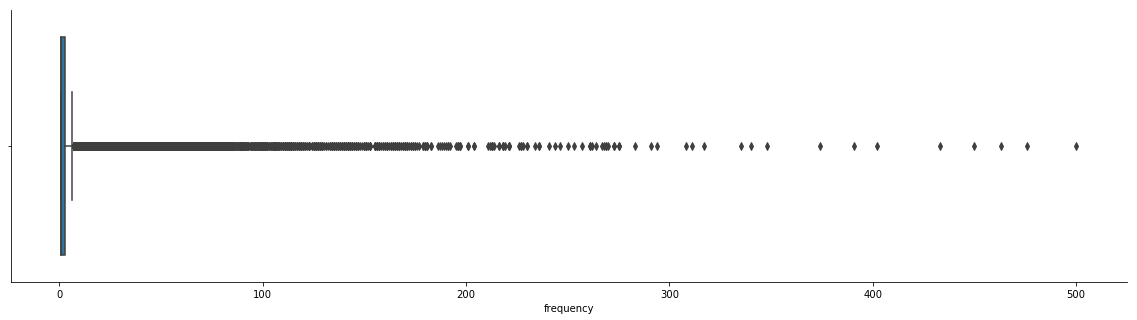

In [56]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='frequency', data=df_songs)
sns.despine()

**What are the most frequent number of times a user listen to the same song?**

In [57]:
listen_counts_temp = listen_counts[listen_counts['count'] > 50].reset_index(drop=False)

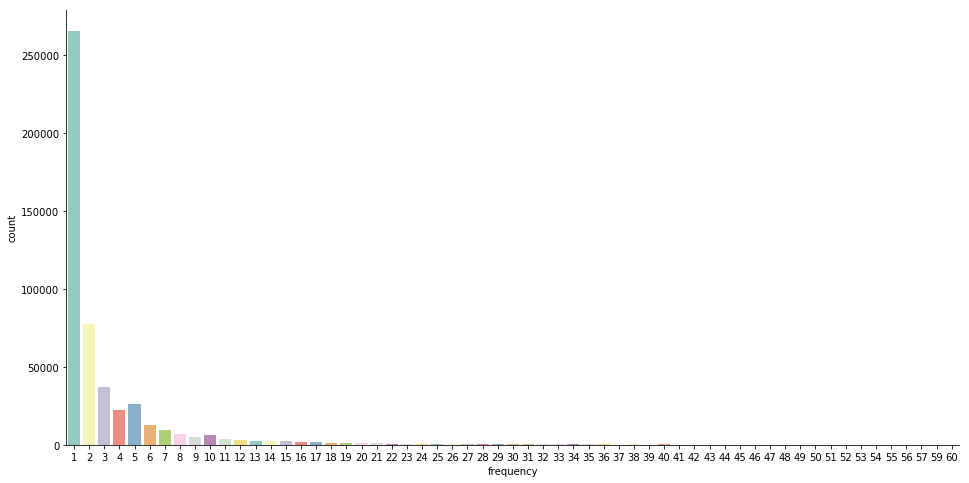

In [58]:
plt.figure(figsize=(16, 8))
sns.barplot(x='frequency', y='count', palette='Set3', data=listen_counts_temp)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

**How many songs does a user listen in average?**

In [59]:
song_user = df_songs.groupby('user_id')['song_id'].count()

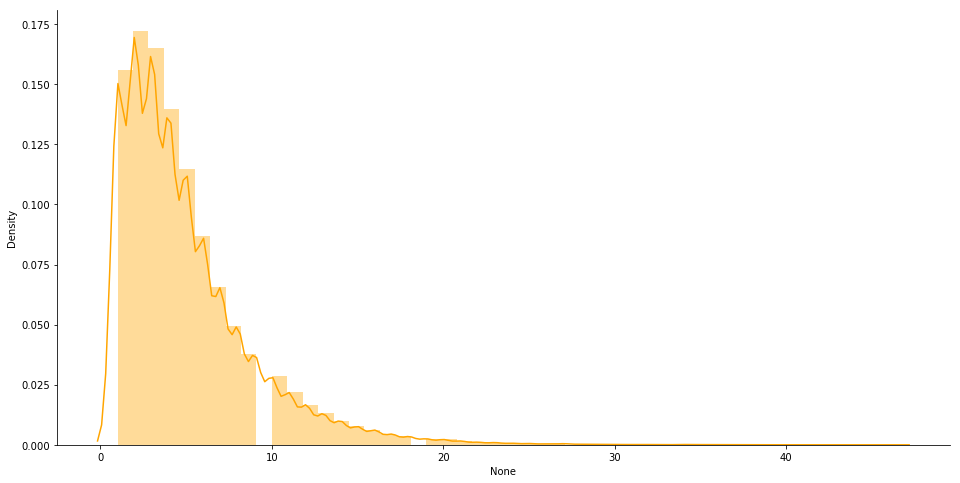

In [60]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [61]:
print(f"A user listens to an average of {np.mean(song_user)} songs")

A user listens to an average of 4.953879382944784 songs


In [62]:
print(f"A user listens to an average of {np.median(song_user)} songs, with minimum {np.min(song_user)} and maximum {np.max(song_user)} songs")

A user listens to an average of 4.0 songs, with minimum 1 and maximum 46 songs


We can see that a user listens in average to 27 songs. Even the maximum amount of songs listen by an user is 711, and we have 9567 songs in our dataset.

So, not all user listen to all songs, so a lot of values in the `song x users` matrix are going to be zero. Thus, we’ll be dealing with extremely sparse data. 

*How sparse?* Let's check that:

In [63]:
# Get how many values should it be if all songs have been listen by all users
values_matrix = unique_users * unique_songs

In [64]:
# Substract the total values with the actural shape of the DataFrame songs
zero_values_matrix = values_matrix - df_songs.shape[0]

In [65]:
print(f"The matrix of users x songs has {zero_values_matrix} values that are zero")

The matrix of users x songs has 623556373 values that are zero


Dealing with such a sparse matrix, we'll take a lot of memory and resources. To make our life easier, let's just select all those users that have listened to at least 16 songs. 

### Prepare the data

In [66]:
# Get users which have listen to at least 16 songs
song_ten_id = song_user[song_user > 16].index.to_list()

In [67]:
# Filtered the dataset to keep only those users with more than 16 listened
df_song_id_more_ten = df_songs[df_songs['user_id'].isin(song_ten_id)].reset_index(drop=True)

We need now to work with a `scipy-sparse matrix` to avoid overflow and wasted memory. For that purpose, we'll use the `csr_matrix` function from `scipy.sparse`.

In [68]:
# convert the dataframe into a pivot table
df_songs_features = df_song_id_more_ten.pivot(index='song_id', columns='user_id', values='frequency').fillna(0)

# obtain a sparse matrix
mat_songs_features = csr_matrix(df_songs_features.values)

Let's take a look at the table `user x song`.

In [69]:
df_songs_features.head()

user_id,0003798d61a8010dbfd8010180b7107cbbb8a649,0011d5f4fb02ff276763d385c3f2ded2b00ad94a,002ee8f7e9d68eafd9dea98a2f093174be98fdb4,00587ee69421cb6abc50898714c23583f1f4e230,005a6d3db8263c1b08cb04b4e78c689dbb7ba6f5,006665569461ff1711a0f3f29c47b5e7ab43edb2,0093ea2ad5eebbfe7635a70909b7988d1b340a5a,00e1946778997bfb860e3cb1dedfcdf487df9d67,00f0fe027bcf6bb8ef4a6c310446781d6098a8e0,01047b99e00bb0743f66bb321bdd62e38fddb0a5,...,fe95c6a6a5290c4069043abf13adec17b548519c,fe9ab375d8c5826f6987a534b7158e404e530b89,ff125cc7b865c5be00d6a1d2a4e0984278cdddc4,ff30c9ddaf0fd5f83b01f2e903fc14d3f7b99099,ff511fa7338117958042d2a698513697a736bc8e,ff77fea5a8d84f5109de17185e2a7fb5d7e2a467,ff80830a101547b5c112e72e939dde33f0a68a1b,ff8e4bd0e848f80a47a3988eb853e81d0cdb5a23,ffee916020d891a74264b8326829742333b79103,ffef132931d961bad8df82a6a8f200fa1aed7746
song_id,,,,,,,,,,,,,,,,,,,,,
SOAAFYH12A8C13717A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAALJB12A8C13C4B6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAMPN12A6310D812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAROC12A6D4FA420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAUKC12AB017F868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Because the system will output the id of the song, instead of the title, we'll make a function that maps those indices with the song title.

In [70]:
df_unique_songs = df_songs.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'release']]

In [71]:
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[df_songs_features.index].release))
}

### Model and recommendations

So, we know that we want to use the model to predict songs. For that, we'll use the `Recommender` class wrote in the `knn_recommender` file.

In [72]:
model = Recommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)

In [83]:
song = 'Cheryl Cole'

In [84]:
new_recommendations = model.make_recommendation(new_song=song, n_recommendations=10)

Starting the recommendation process for Cheryl Cole ...
... Done


In [85]:
print(f"The recommendations for {song} are:")
print(f"{new_recommendations}")

The recommendations for Cheryl Cole are:
['Me Da Igual', 'Con Mis Manos', 'Miracle Town', 'Cosas Del Amor', 'Hacer El Amor Con Otro', 'Go Away Angels', 'Please and Thank You', 'I Can Tell', 'Heroe', 'Si Tú No Estás']
